# PS4: Gradient descent and regularization
This is a fun but challenging problem set. It will test your python skills, as well as your understanding of the material in class and in the readings. Start early and debug often! Some notes:

* Part 1 is meant to be easy, so get through it quickly.
* Part 2 (especially 2.1) will be difficult, but it is the lynchpin of this problem set so make sure to do it well and understand what you've done. If you find your gradient descent algorithm is taking more than a few minutes to complete, debug more, compare notes with others, and go to the TA sessions (especially the sections on vectorized computation and computational efficiency).
* Depending on how well you've done 2.1, parts 2.3 and 4.3 will be relatively painless or incredibly painful. 
* Part 4 (especially 4.3) will be computationally intensive. Don't leave this until the last minute, otherwise your code might be running when the deadline arrives.
* Do the extra credit problems last.

---

## Introduction to the assignment

As with the last assignment, you will be using a modified version of the [California Housing Prices Dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html). Please download the csv file from bcourses ('cal_housing_data_clean_ps4.csv'). 

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

from sklearn.linear_model import Ridge

In [2]:
# Load the California Housing Dataset 
cal_df = pd.read_csv('cal_housing_data_clean_ps4.csv')

# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=1948)

---

# Part 1: Getting oriented


### 1.1 Use existing libraries

Soon, you will write your own gradient descent algorithm, which you will then use to minimize the squared error cost function.  First, however, let's use the canned versions that come with Python, to make sure we understand what we're aiming to achieve.

Use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to explore the relationship between median housing value and median income in California's census block groups. 

(a) Regress the median housing value `MedHouseVal` on the median income `MedInc`. Draw a scatter plot of housing price (y-axis) against income (x-axis), and draw the regression line in blue.  You might want to make the dots semi-transparent if it improves the presentation of the figure. 

(b) Regress the median housing value on median income and median income squared.  Plot this new (curved) regression line in gold, on the same axes used for part (a). 

(c) Interpret your results.

In [3]:
# Your code here

regr_1 = LinearRegression()
regr_1.fit(cal_df[['MedInc']], cal_df['MedHouseVal'])
r_1 = regr_1.score(cal_df[['MedInc']], cal_df['MedHouseVal'])

print('First regression')
print('Coefficient: {:.2f}'.format(regr_1.coef_[0]))
print('Intercept: {:.2f}'.format(regr_1.intercept_))
print('R squared: {:.2f}'.format(r_1))

First regression
Coefficient: 0.16
Intercept: 1.58
R squared: 0.16


In [4]:
# Regression on linear term and quadratic term
cal_df['MedInc_sq'] = cal_df['MedInc'] ** 2

regr_2 = LinearRegression()
regr_2.fit(cal_df[['MedInc', 'MedInc_sq']], cal_df['MedHouseVal'])
r_2 = regr_2.score(cal_df[['MedInc', 'MedInc_sq']], cal_df['MedHouseVal'])
print('\nSecond regression')
print('Coefficient of MedInc: {:.2f}'.format(regr_2.coef_[0]))
print('Coefficient of MedInc_squ: {:.2f}'.format(regr_2.coef_[1]))
print('Intercept: {:.2f}'.format(regr_2.intercept_))
print('R squared: {:.2f}'.format(r_2))


Second regression
Coefficient of MedInc: -0.11
Coefficient of MedInc_squ: 0.03
Intercept: 2.10
R squared: 0.18


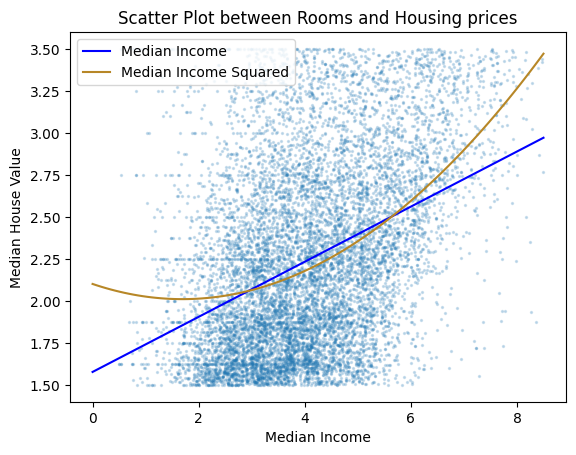

In [5]:
# Plot of linear and quadratic regression lines
plt.scatter(cal_df['MedInc'],cal_df['MedHouseVal'],marker='o',alpha = 0.2, s=2)
plt.title("Scatter Plot between Rooms and Housing prices")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
grid_x = np.linspace(0,8.5,100)
y = [regr_1.coef_[0]*x + regr_1.intercept_ for x in grid_x]
y_2 = [regr_2.coef_[1]*x**2 + regr_2.coef_[0]*x + regr_2.intercept_ for x in grid_x]
plt.plot(grid_x, y, color='blue',label = 'Median Income')
plt.plot(grid_x, y_2 , color='#b78727' , label = 'Median Income Squared')
plt.legend()

The r squared increases with the addition of the quadratic term. This could reflect that the quadratic term is a more appropriate fit for the data; however, it's also the case that r2 will always increase (on the training set) with an increase in the number and complexity of the predictor variables.

### 1.2 Training and testing

Chances are, for the above problem you used all of your data to fit the regression line. In some circumstances this is a reasonable thing to do, but if your primary objective is prediction, you should be careful about overfitting. Let's redo the above results the ML way, using careful cross-validation.  Since you are now experts in cross-validation, and have written your own cross-validation algorithm from scratch, you can now take a shortcut and use the libraries that others have built for you.

Using the [cross-validation functions](http://scikit-learn.org/stable/modules/cross_validation.html) from scikit-learn, use 5-fold cross-validation to fit the regression model (a) from 1.1, i.e. the linear fit of median housing value on median income. Each fold of cross-validation will give you one slope coefficient and one intercept coefficient.  Create a new scatterplot of housing price against rooms, and draw the five different regression lines in light blue, and the original regression line from 1.1 in red (which was estimated using the full dataset). What do you notice?

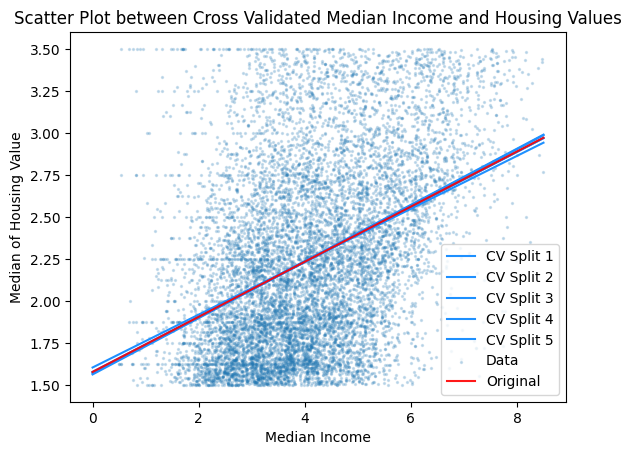

In [6]:
from sklearn.model_selection import KFold

# your code here

kf = KFold(n_splits=5,shuffle=True)
slope = []
intercept = []
counter = 1
grid_x = np.linspace(0,8.5,100)

for train_index, test_index in kf.split(cal_df):
    regr = LinearRegression()
    df_train = cal_df.iloc[train_index]
    regr.fit(df_train[['MedInc']], df_train['MedHouseVal'])
    y = [regr.coef_[0]*x + regr.intercept_ for x in grid_x]
    plt.plot(grid_x, y, color='dodgerblue', label = 'CV Split %i' % counter)
    counter += 1

plt.title("Scatter Plot between Cross Validated Median Income and Housing Values")
plt.xlabel("Median Income")
plt.ylabel("Median of Housing Value")
plt.scatter(cal_df['MedInc'],cal_df['MedHouseVal'],marker='o',alpha = 0.2,label = 'Data',s=2)

regr.fit(cal_df[['MedInc']], cal_df['MedHouseVal'])
y = [regr.coef_[0]*x + regr.intercept_ for x in grid_x]
plt.plot(grid_x, y, color='red',label = 'Original',alpha=0.9)

plt.legend()
plt.show()

Each of the linear regressions estimated on one of the cross-validation splits is very similar to the overall regression line (though not exactly the same). It appears that the variance in both slopes and intercepts is quite small.

# Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (median income)

Implement the batch gradient descent algorithm that we discussed in class. Use the version you implement to regress the median house value on the median income. Experiment with 3-4 different values of the learning rate *R*, and do the following:

* Report the values of alpha and beta that minimize the loss function
* Report the number of iterations it takes for your algorithm to converge (for each value of *R*)
* Report the total running time of your algorithm, in seconds
* How do your coefficients compare to the ones estimated through standard libraries in 1.1? Does this depend on *R*?

Some skeleton code is provided below, but you should feel free to delete this code and start from scratch if you prefer.

* *Hint 1: Don't forget to implement a stopping condition, so that at every iteration you check whether your results have converged. Common approaches to this are to (a) check to see if the loss has stopped decreasing; and (b) check if both your current parameter esimates are close to the estimates from the previous iteration.  In both cases, "close" should not be ==0, it should be <=epsilon, where epsilon is something very small (like 0.0001).*
* *Hint 2: We recommend including a MaxIterations parameter in their gradient descent algorithm, to make sure things don't go off the rails, i.e., as a safeguard in case your algorithm isn't converging as it should. *

In [7]:
import time

"""
Function
--------
bivariate_ols
    Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

Parameters
----------
xvalues, yvalues : narray
    xvalues: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta: float
    coefficient
"""
def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000):
    # initialize the parameters
    start_time = time.time()
    alpha = 0.0
    beta = 0.0
    n = len(xvalues)
    #cost = np.inf
    epsilon = 1e-6
    xvaluest = np.array(xvalues)
    yvaluest = np.array(yvalues)
    for i in range(MaxIterations):
        alpha_old = alpha
        beta_old = beta
        #cost_old = cost
        alpha -= R / n * ((alpha + beta * xvaluest - yvaluest).sum())
        beta -= R / n * (((alpha_old + beta * xvaluest - yvaluest) * xvaluest).sum())
        #cost = 1.0 / (2 * n) * (((alpha + beta * xvaluest - yvaluest) ** 2).sum())
        if abs(alpha - alpha_old) < epsilon and abs(beta - beta_old) < epsilon:
            print(f'cost < {epsilon}, stopped after {i} iterations')
            break
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta


print("OLS  model parameters\n intercept: {:.3f}, coefficient: {:.3f}".format(regr_1.intercept_, regr_1.coef_[0]))

print('\nExperiment 1: R=0.001')
print(bivariate_ols(cal_df['MedInc'], cal_df['MedHouseVal'], 0.001, 100000))

print('\nExperiment 2: R=0.01')
print(bivariate_ols(cal_df['MedInc'], cal_df['MedHouseVal'], 0.01, 100000))

print('\nExperiment 3: R=0.1')
print(bivariate_ols(cal_df['MedInc'], cal_df['MedHouseVal'], 0.1, 1000000))

OLS  model parameters
 intercept: 1.577, coefficient: 0.164

Experiment 1: R=0.001
cost < 1e-06, stopped after 53246 iterations
Time taken: 2.86 seconds
(1.5664128483781539, 0.16642185499468876)

Experiment 2: R=0.01
cost < 1e-06, stopped after 7820 iterations
Time taken: 0.46 seconds
(1.576178060210253, 0.16424726976540396)

Experiment 3: R=0.1
cost < 1e-06, stopped after 1028 iterations
Time taken: 0.05 seconds
(1.5771547974068545, 0.16402976313911236)


### 2.2 Data normalization (done for you!)

Soon, you will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code to standardize your features. 

**For all the following questions, unless explicitly asked otherwise, you are expected to standardize appropriately. Recall that in settings where you are using holdout data for validation or testing purposes, this involves substracting the average and dividing by the standard deviation of your training data.**

In [8]:
'''
Function
--------
standardize
    Column-wise standardization of a target dataframe using the mean and std of a reference dataframe

Parameters
----------
ref,tar : pd.DataFrame
    ref: reference dataframe
    tar: target dataframe
    
Returns
-------
tar_norm: pd.DataFrame
    Standardized target dataframe
'''
def standardize(ref,tar):
    tar_norm = ((tar - np.mean(ref, axis = 0)) / np.std(ref, axis = 0))
    return tar_norm

# Examples
# Standardize train: standardize(ref=x_train,tar=x_train)
# Standardize test: standardize(ref=x_train,tar=x_test)

### 2.3 Implement gradient descent with an arbitrary number of independent variables

Now that you have a simple version of gradient descent working, create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.  Test your algorithm using `MedInc`, `HouseAge` and `AveRooms` as independent variables. Remember to standardize appropriately before inputting them to the gradient descent algorithm. How do your coefficients compare to the ones estimated through standard libraries?

As before,  report and interpret your estimated coefficients, the number of iterations before convergence, and the total running time of your algorithm. Experiment with three values of R (0.1, 0.01, and 0.001).

* *Hint 1: Be careful to implement this efficiently, otherwise it might take a long time for your code to run. Commands like `np.dot` can be a good friend to you on this problem*

In [9]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    coefficient
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)[:, np.newaxis]
    n, variable_n = xvalue_matrix.shape 
    alpha = 0.0
    beta_array = np.transpose(np.array([[0.0] * variable_n]))
    cost = np.inf
    epsilon = 0.00001
    for i in range(MaxIterations):
        cost_old = cost
        alpha_old = alpha
        beta_array_old = np.copy(beta_array)
        part_1 = alpha_old + np.dot(xvalue_matrix, beta_array_old) - yvalues
        alpha -= R / n * (part_1.sum())
        beta_array -= R / n * (np.dot(xvalue_matrix.T, part_1))
        part_2 = alpha + np.dot(xvalue_matrix, beta_array) - yvalues
        cost = 1.0 / (2 * n) * ((part_2 ** 2).sum())
        if abs(alpha-alpha_old) < epsilon and max(abs(beta_array-beta_array_old)) < epsilon:
            print('cost < 0.00001 stopped after iteration times: {}'.format(i))
            break
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta_array

features = cal_df[['MedInc', 'HouseAge', 'AveRooms']]
features_norm = standardize(features, features)

print('\nExperiment 1: R=0.001')
print(multivariate_ols(features_norm, cal_df['MedHouseVal'], 0.001, 100000))

print('\nExpeirment 2: R=0.01')
print(multivariate_ols(features_norm, cal_df['MedHouseVal'], 0.01, 100000))

print('\mExperiment 3: R=0.1')
print(multivariate_ols(features_norm, cal_df['MedHouseVal'], 0.1, 100000))

regr_3 = LinearRegression()
regr_3.fit(features_norm, cal_df['MedHouseVal'])
print('\nIntercept: {:.2f}'.format(regr_3.intercept_))
print('Coefficient of MedIncNorm: {:.8f}'.format(regr_3.coef_[0]))
print('Coefficient of HouseAgeNorm: {:.8f}'.format(regr_3.coef_[1]))
print('Coefficient of AveRoomsNorm: {:.8f}'.format(regr_3.coef_[2]))


Experiment 1: R=0.001
cost < 0.00001 stopped after iteration times: 5412
Time taken: 0.56 seconds
(2.235886902366469, array([[ 0.24763335],
       [ 0.08365945],
       [-0.02608215]]))

Expeirment 2: R=0.01
cost < 0.00001 stopped after iteration times: 774
Time taken: 0.08 seconds
(2.2449420911837707, array([[ 0.25285591],
       [ 0.08606539],
       [-0.02966111]]))
\mExperiment 3: R=0.1
cost < 0.00001 stopped after iteration times: 112
Time taken: 0.01 seconds
(2.2458573092157748, array([[ 0.25433099],
       [ 0.08665809],
       [-0.03075474]]))

Intercept: 2.25
Coefficient of MedIncNorm: 0.25448610
Coefficient of HouseAgeNorm: 0.08671268
Coefficient of AveRoomsNorm: -0.03087640


We observe that higher learning rates converge much faster than smaller ones (e.g. 112 iterations to convergence for R=0.1, vs. 5,412 for R=0.001). It looks like for this problem all three learning rates converged successfully, in that the parameters are similar to those obtained by scikit-learn's OLS functionality.

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time do not standardize your variables - i.e., use the original data. Use the same three values of R (0.1, 0.01, and 0.001). What do you notice about the running time and convergence properties of your algorithm? Compare to the results you would obtain using standard libraries. 

In [10]:
# Your code here

print('\nExperiment 1: R=0.001')
print(multivariate_ols(features, cal_df['MedHouseVal'], 0.001, 100000))

print('\nExperiment 2: R=0.01')
print(multivariate_ols(features, cal_df['MedHouseVal'], 0.01, 100000))

print('\nExperiment 3: R=0.1')
print(multivariate_ols(features, cal_df['MedHouseVal'], 0.1, 100000))

regr_3 = LinearRegression()
regr_3.fit(features, cal_df['MedHouseVal'])
print('\nIntercept: {:.2f}'.format(regr_3.intercept_))
print('Coefficient of MedInc: {:.10f}'.format(regr_3.coef_[0]))
print('Coefficient of HouseAgeNorm: {:.10f}'.format(regr_3.coef_[1]))
print('Coefficient of AveRoomsNorm: {:.10f}'.format(regr_3.coef_[2]))


Experiment 1: R=0.001
cost < 0.00001 stopped after iteration times: 40439
Time taken: 4.20 seconds
(1.1046553800660386, array([[ 0.21690079],
       [ 0.00985764],
       [-0.00614269]]))

Experiment 2: R=0.01


/Users/simonramirezamaya/berkeley/INFO_251/venv_aml/lib/python3.7/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/simonramirezamaya/berkeley/INFO_251/venv_aml/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in square
/Users/simonramirezamaya/berkeley/INFO_251/venv_aml/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract


Time taken: 10.50 seconds
(nan, array([[nan],
       [nan],
       [nan]]))

Experiment 3: R=0.1
Time taken: 11.07 seconds
(nan, array([[nan],
       [nan],
       [nan]]))

Intercept: 1.34
Coefficient of MedInc: 0.1907790241
Coefficient of HouseAgeNorm: 0.0069880089
Coefficient of AveRoomsNorm: -0.0135034490


When we do not standardize our features, our algorithm does not always converge, or it takes a very long time to do so. However, for an appropriate learning rate, it may be possible to achieve convergence.

# 3. Prediction

Let's use our fitted model to make predictions about housing prices. 

### 3.1 Cross-Validation

Unless you were careful above, you probably overfit your data again. Let's fix that. Use 5-fold cross-validation to re-fit the multivariate regression from 2.3 above, and report your estimated coefficients (there should be four, corresponding to the intercept and the three coefficients for `MedInc` and `AveRoomsNorm`, `HouseAgeNorm`). Since there are 5 folds, there will be 5 sets of four coefficients -- report them all in a 5x4 table.

**Note:** You can use KFold to perform the cross-validation. 

In [11]:
# Your code here
def compute_rmse(predictions, yvalues):
    P = np.array(predictions)
    Y = np.array(yvalues)
    rmse = ((P-Y)**2).sum()*1.0 / len(P) 
    rmse = np.sqrt(rmse)
    return rmse

kf = KFold(n_splits=5,shuffle=True)
slope = []
r_all = []
rmse_all = []
for train_index, test_index in kf.split(cal_df):

    df_train = cal_df.iloc[train_index]
    df_test = cal_df.iloc[test_index]
    
    df_train_norm = standardize(df_train,df_train)
    df_test_norm = standardize(df_train,df_test)
    
    alpha, beta_array = multivariate_ols(df_train_norm[['MedInc', 'AveRooms', 'HouseAge']], df_train['MedHouseVal'], 0.001, 100000)
    r_all.append([alpha, beta_array[0][0], beta_array[1][0], beta_array[2][0]])
    
    predict = alpha + beta_array[0][0] * df_test_norm['MedInc'] + beta_array[1][0] * df_test_norm['AveRooms'] + beta_array[2][0] * df_test_norm['HouseAge']
    rmse_this = compute_rmse(predict, df_test['MedHouseVal'])
    rmse_all.append(rmse_this)
    
results = pd.DataFrame(r_all)
results.columns = ['Intercept', 'MedInc', 'AveRooms', 'HouseAge']
results.index = ['CV Split %i' % i for i in range(1, 6)]
results

cost < 0.00001 stopped after iteration times: 5413
Time taken: 0.52 seconds
cost < 0.00001 stopped after iteration times: 5410
Time taken: 0.50 seconds
cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.51 seconds
cost < 0.00001 stopped after iteration times: 5412
Time taken: 0.54 seconds
cost < 0.00001 stopped after iteration times: 5411
Time taken: 0.51 seconds


,Intercept,MedInc,AveRooms,HouseAge
CV Split 1,2.237141,0.254754,-0.025649,0.088795
CV Split 2,2.232370,0.242334,-0.026281,0.081069
CV Split 3,2.240746,0.252258,-0.022148,0.083194
CV Split 4,2.234744,0.245067,-0.029241,0.085102
CV Split 5,2.234435,0.243395,-0.026458,0.080159


As with problems 1.1 and 1.2, we see that the distribution of parameter estimates from k-fold cross-validation are close to the parameters estimated without carefully separating our training and testing datasets. Small deviations are expected, as the parameters are being fit on a subset of the original data.

### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. Compute the cross-validated RMSE for each of the 5 folds above. In other words, in fold 1, use the parameters estimated on the 80% of the data to make predictions for the 20%, and calculate the RMSE for those 20%. Repeate this for the remaining folds. Report the RMSE for each of the 5-folds, and the average (mean) RMSE across the five folds. How does this average RMSE compare to the performance of your nearest neighbor algorithm from the last problem set?

In [12]:
# Your code here
#Printing RMSE for each fold
print(pd.Series(rmse_all,index = [1,2,3,4,5]))

#Printing RMSE for average
print('Mean RMSE: {:.2f}'.format(np.mean(rmse_all)))

1    0.495541
2    0.492695
3    0.494327
4    0.484354
5    0.494372
dtype: float64
Mean RMSE: 0.49


The RMSE on all splits is slightly below 0.5. This is an improvement over the performance of the KNN models considered in problem set 3 (RMSE close to 0.7 when K was optimized).

## 4 Regularization 

### 4.1 Get prepped

Step 1: Generate features consisting of all polynomial combinations of degree greater than 0 and less than or equal to 3 of the following features: `MedInc`, `HouseAge` and `AveRooms`. If you are using PolynomialFeatures of sklearn.preprocessing make sure you drop the constant polynomial feature (degree 0). You should have a total of 19 polynomial features. 

Step 2: Randomly sample 80% of your data and call this the training set, and set aside the remaining 20% as your test set.

In [13]:
# Your code here
from sklearn.preprocessing import PolynomialFeatures

#features = ['MedInc','HouseAge','AveRooms','AveOccup','DistCoast','AveBedrms','Population']
features = ['MedInc','HouseAge','AveRooms']
    
poly = PolynomialFeatures(degree=3)
trans = poly.fit_transform(cal_df[features])
names = [name.replace(" ", "_") for name in poly.get_feature_names_out()]
cal_poly_df = pd.DataFrame(trans,columns=names,index=cal_df.index)
cal_poly_df = cal_poly_df.drop(['1'],axis=1)

cal_poly_df['MedHouseVal'] = cal_df['MedHouseVal']

n = len(cal_poly_df)
last_obs_train = int(np.floor(n*0.80))
index_values = cal_poly_df.index.values
np.random.shuffle(index_values)

cal_poly_df_train = cal_poly_df.loc[index_values[0:last_obs_train],:]
cal_poly_df_test = cal_poly_df.loc[index_values[last_obs_train:],:]

In [ ]:
cal_poly_df

### 4.2 Complexity and overfitting?

Now, using your version of multivariate regression from 2.3, let's try to build a more complex model. **Remember to standardize appropriately!** Using the training set, regress the median house value on the polynomial features using your multivariate ols algorithm. Calculate train and test RMSE. Is this the result that you were expecting? How do these numbers compare to each other, and to the RMSE from 3.2 and nearest neighbors?

In [14]:
import random

features = list(cal_poly_df.columns[:-1])

res_train = []
res_test = []

x_train = cal_poly_df_train[features]
x_train_norm = standardize(x_train,x_train)
y_train = cal_poly_df_train['MedHouseVal']
alpha, betas = multivariate_ols(x_train_norm, y_train, 0.0001, 100000)  
y_hat_train = alpha
for i in range(len(features)):
    y_hat_train += betas[i] * x_train_norm.iloc[:,i]
rmse_train = compute_rmse(y_hat_train,y_train)
res_train.append(rmse_train)
print(rmse_train)

x_test = cal_poly_df_test[features]
x_test_norm = standardize(x_train,x_test)
y_test = cal_poly_df_test['MedHouseVal']
y_hat_test = alpha
for i in range(len(features)):
    y_hat_test += betas[i] * x_test_norm.iloc[:,i]
rmse_test = compute_rmse(y_hat_test,y_test)
res_test.append(rmse_test)
print(rmse_test,"\n")

cost < 0.00001 stopped after iteration times: 31135
Time taken: 3.54 seconds
0.4962912603789041
0.48689039472147083 



The train and test RMSE are similar to those reported in 3.2. Unexpectedly, the test RMSE is smaller than the train RMSE, which suggests that overfitting is probably not a big concern in this setting despite the fact that we are using the polynomial features. 

### 4.3 Ridge regularization (basic)
Incorporate L2 (Ridge) regularization into your multivariate_ols regression. Write a new version of your gradient descent algorithm that includes a regularization term "lambda" to penalize excessive complexity. 

Use your regularized regression to re-fit the model using all the polynomial features on your training data and using the value lambda = 10^4.  Report the RMSE obtained for your training data, and the RMSE obtained for your testing data.

In [15]:
def multivariate_regularized_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000,lmbda=0):
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)[:, np.newaxis]
    n, variable_n = xvalue_matrix.shape 
    alpha = 0.0
    beta_array = np.transpose(np.array([[0.0] * variable_n]))
    #cost = np.inf
    epsilon = 0.00001
    for i in range(MaxIterations):
        #cost_old = cost
        alpha_old = alpha
        beta_array_old = np.copy(beta_array)
        part_1 = alpha_old + np.dot(xvalue_matrix, beta_array_old) - yvalues
        alpha -= (R/n * (part_1.sum()))
        beta_array -= (R/n * (np.dot(xvalue_matrix.T, part_1)) + (R/n)*lmbda*beta_array)
        part_2 = alpha + np.dot(xvalue_matrix, beta_array) - yvalues
        #cost = 1.0 / (2 * n) * ((part_2 ** 2).sum())
        if abs(alpha-alpha_old) < epsilon and max(abs(beta_array-beta_array_old)) < epsilon:
            print('cost < 0.00001 stopped after iteration times: {}'.format(i))
            break
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta_array

In [16]:
alpha, betas = multivariate_regularized_ols(x_train_norm,y_train,R=0.001, MaxIterations=10**5, lmbda=10000)
y_hat_train = alpha
for i in range(len(features)-1):
    y_hat_train += betas[i] * x_train_norm.iloc[:,i]
rmse_train = compute_rmse(y_hat_train,y_train)
res_train.append(rmse_train)
print(rmse_train)

y_hat_test = alpha
for i in range(len(features)-1):
    y_hat_test += betas[i] * x_test_norm.iloc[:,i]
rmse_test = compute_rmse(y_hat_test,y_test)
res_test.append(rmse_test)
print(rmse_test,"\n")

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.54 seconds
0.4912431994586569
0.48651417688022325 



### 4.4: Cross-validate lambda

This is where it all comes together! Use k-fold cross-validation to select the optimal value of lambda in a regression using all the polynomial features. In other words, define a set of different values of lambda. Then, using the 80% of your data that you set aside for training, iterate through the values of lambda one at a time. For each value of lambda, use k-fold cross-validation to compute the average cross-validated RMSE for that lambda value, computed as the average across the held-out folds. You should also record the average cross-validated train RMSE, computed as the average across the folds used for training. Create a scatter plot that shows RMSE as a function of lambda. The scatter plot should have two lines: a gold line showing the cross-validated RMSE, and a blue line showing the cross-validated train RMSE.  At this point, you should not have touched your held-out 20% of "true" test data.

What value of lambda minimizes your cross-validated RMSE? Fix that value of lambda, and train a new model using all of your training data with that value of lambda (i.e., use the entire 80% of the data that you set aside in 4.1). Calculate the RMSE for this model on the 20% of "true" test data. How does your test RMSE compare to the RMSE from 3.2, 4.2, 4.3 and to the RMSE from nearest neighbors? What do you make of these results? 

Go brag to your friends about how you just implemented cross-validated ridge-regularized multivariate regression using gradient descent optimization, from scratch!

In [17]:
# Your code here
lambdas = list(list(np.linspace(1, 100, num=10)) + list(np.linspace(200, 1000, num=10)) + list(np.linspace(2000, 10000, num=10)) + list(np.linspace(20000, 100000, num=10)))
lambdas.insert(0,0)

def k_fold(ds, k):
    r = []
    size_all = len(ds)
    size = int(size_all / k)
    ds_index = list(range(size_all))
    for i in range(k-1):
        np.random.seed(seed=i)
        rows = np.random.choice(ds_index, size, replace=False)
        r.append(rows.tolist())
        ds_index = list(set(ds_index) - set(rows))
    r.append(ds_index)
    return r

dict_lbd_rmse_train = {}
dict_lbd_rmse_val = {}

dict_lbd_rmse_train_ridge = {}
dict_lbd_rmse_val_ridge = {}

for lbd in lambdas:
    
    print("\n",f"lambda = {lbd}")
    counter = 0
    rmse_train_sum = 0
    rmse_val_sum = 0
    
    rmse_train_ridge_sum = 0
    rmse_val_ridge_sum = 0
    
    size_all = len(x_train)
    ds_fold = k_fold(x_train,5)
    ds_index = list(range(size_all))

    for i in range(5):

        val_idx = ds_fold[i]
        train_idx = list(set(ds_index) - set(val_idx))
        
        x_train_train = x_train.iloc[train_idx,:]
        x_train_train_norm = standardize(x_train_train,x_train_train)
        y_train_train = y_train.iloc[train_idx]
        
        x_train_val = x_train.iloc[val_idx,:]
        x_train_val_norm = standardize(x_train_train,x_train_val)
        y_train_val = y_train.iloc[val_idx]

        R = 0.001
        alpha, betas = multivariate_regularized_ols(x_train_train_norm, y_train_train, R, 100000,lbd)
        #print(alpha,betas)
        
        clf = Ridge(alpha=lbd)
        clf.fit(x_train_train_norm, y_train_train)
        rmse_train_ridge = compute_rmse(clf.predict(x_train_train_norm),y_train_train)
        print(f'Train RMSE ridge: {round(rmse_train_ridge,4)}')
        rmse_train_ridge_sum += rmse_train_ridge
        
        rmse_val_ridge = compute_rmse(clf.predict(x_train_val_norm),y_train_val)
        print(f'Test RMSE ridge: {round(rmse_val_ridge,4)}')
        rmse_val_ridge_sum += rmse_val_ridge
        
        y_hat_train = alpha
        for i in range(len(features)):
            y_hat_train += betas[i] * x_train_train_norm.iloc[:,i]
        rmse_train = compute_rmse(y_hat_train,y_train_train)
        print(f'Train RMSE: {round(rmse_train,4)}')
        rmse_train_sum += rmse_train

        y_hat_val = alpha
        for i in range(len(features)):
            y_hat_val += betas[i] * x_train_val_norm.iloc[:,i]
        rmse_val = compute_rmse(y_hat_val,y_train_val)
        print(f'Test RMSE: {round(rmse_val,4)} \n')
        rmse_val_sum += rmse_val
        counter += 1.0

    dict_lbd_rmse_train_ridge[lbd] = rmse_train_ridge_sum / counter
    dict_lbd_rmse_val_ridge[lbd] = rmse_val_ridge_sum / counter
    
    dict_lbd_rmse_train[lbd] = rmse_train_sum / counter
    dict_lbd_rmse_val[lbd] = rmse_val_sum / counter


 lambda = 0
cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.47 seconds
Train RMSE ridge: 0.4796
Test RMSE ridge: 0.4885
Train RMSE: 0.4846
Test RMSE: 0.4901 

cost < 0.00001 stopped after iteration times: 5413
Time taken: 0.48 seconds
Train RMSE ridge: 0.4812
Test RMSE ridge: 0.4792
Train RMSE: 0.4862
Test RMSE: 0.4839 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.47 seconds
Train RMSE ridge: 0.4821
Test RMSE ridge: 0.4756
Train RMSE: 0.4872
Test RMSE: 0.4795 

cost < 0.00001 stopped after iteration times: 5415
Time taken: 0.48 seconds
Train RMSE ridge: 0.4778
Test RMSE ridge: 0.4926
Train RMSE: 0.4829
Test RMSE: 0.4964 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.48 seconds
Train RMSE ridge: 0.4817
Test RMSE ridge: 5.7999
Train RMSE: 0.4865
Test RMSE: 0.7197 


 lambda = 1.0
cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.48 seconds
Train RMSE ridge: 0.4799
Test RMSE ridge: 0.4883
Train RMSE: 0.4846
Test RMS

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.59 seconds
Train RMSE ridge: 0.4836
Test RMSE ridge: 0.4891
Train RMSE: 0.4847
Test RMSE: 0.4901 

cost < 0.00001 stopped after iteration times: 5413
Time taken: 0.53 seconds
Train RMSE ridge: 0.4852
Test RMSE ridge: 0.4825
Train RMSE: 0.4863
Test RMSE: 0.484 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.53 seconds
Train RMSE ridge: 0.486
Test RMSE ridge: 0.4791
Train RMSE: 0.4873
Test RMSE: 0.4796 

cost < 0.00001 stopped after iteration times: 5415
Time taken: 0.51 seconds
Train RMSE ridge: 0.4817
Test RMSE ridge: 0.496
Train RMSE: 0.483
Test RMSE: 0.4965 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.56 seconds
Train RMSE ridge: 0.4855
Test RMSE ridge: 0.6587
Train RMSE: 0.4866
Test RMSE: 0.6991 


 lambda = 200.0
cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.52 seconds
Train RMSE ridge: 0.4839
Test RMSE ridge: 0.4894
Train RMSE: 0.4848
Test RMSE: 0.4902 

cos

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.54 seconds
Train RMSE ridge: 0.4868
Test RMSE ridge: 0.6185
Train RMSE: 0.4872
Test RMSE: 0.5804 


 lambda = 1000.0
cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.52 seconds
Train RMSE ridge: 0.4849
Test RMSE ridge: 0.4901
Train RMSE: 0.4853
Test RMSE: 0.4905 

cost < 0.00001 stopped after iteration times: 5413
Time taken: 0.53 seconds
Train RMSE ridge: 0.4865
Test RMSE ridge: 0.4843
Train RMSE: 0.4868
Test RMSE: 0.4849 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.52 seconds
Train RMSE ridge: 0.4875
Test RMSE ridge: 0.4801
Train RMSE: 0.4879
Test RMSE: 0.4803 

cost < 0.00001 stopped after iteration times: 5415
Time taken: 0.54 seconds
Train RMSE ridge: 0.4832
Test RMSE ridge: 0.4968
Train RMSE: 0.4836
Test RMSE: 0.497 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.52 seconds
Train RMSE ridge: 0.4869
Test RMSE ridge: 0.6053
Train RMSE: 0.4873
Test RMSE: 0.5717 


cost < 0.00001 stopped after iteration times: 5415
Time taken: 0.52 seconds
Train RMSE ridge: 0.4892
Test RMSE ridge: 0.5021
Train RMSE: 0.4893
Test RMSE: 0.502 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.52 seconds
Train RMSE ridge: 0.4933
Test RMSE ridge: 0.489
Train RMSE: 0.4934
Test RMSE: 0.4892 


 lambda = 10000.0
cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.52 seconds
Train RMSE ridge: 0.4914
Test RMSE ridge: 0.4949
Train RMSE: 0.4915
Test RMSE: 0.4951 

cost < 0.00001 stopped after iteration times: 5413
Time taken: 0.52 seconds
Train RMSE ridge: 0.4926
Test RMSE ridge: 0.4922
Train RMSE: 0.4927
Test RMSE: 0.4925 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.52 seconds
Train RMSE ridge: 0.4938
Test RMSE ridge: 0.4874
Train RMSE: 0.4939
Test RMSE: 0.4874 

cost < 0.00001 stopped after iteration times: 5415
Time taken: 0.53 seconds
Train RMSE ridge: 0.4897
Test RMSE ridge: 0.5025
Train RMSE: 0.4898
Test RMSE: 0.5025 


cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.57 seconds
Train RMSE ridge: 0.5208
Test RMSE ridge: 0.5166
Train RMSE: 0.5209
Test RMSE: 0.5166 

cost < 0.00001 stopped after iteration times: 5415
Time taken: 0.58 seconds
Train RMSE ridge: 0.5177
Test RMSE ridge: 0.5275
Train RMSE: 0.5178
Test RMSE: 0.5274 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.59 seconds
Train RMSE ridge: 0.52
Test RMSE ridge: 0.513
Train RMSE: 0.5201
Test RMSE: 0.5131 


 lambda = 100000.0
cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.57 seconds
Train RMSE ridge: 0.5209
Test RMSE ridge: 0.5209
Train RMSE: 0.521
Test RMSE: 0.521 

cost < 0.00001 stopped after iteration times: 5413
Time taken: 0.58 seconds
Train RMSE ridge: 0.5208
Test RMSE ridge: 0.5234
Train RMSE: 0.5209
Test RMSE: 0.5237 

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.58 seconds
Train RMSE ridge: 0.5222
Test RMSE ridge: 0.5181
Train RMSE: 0.5223
Test RMSE: 0.5181 

c

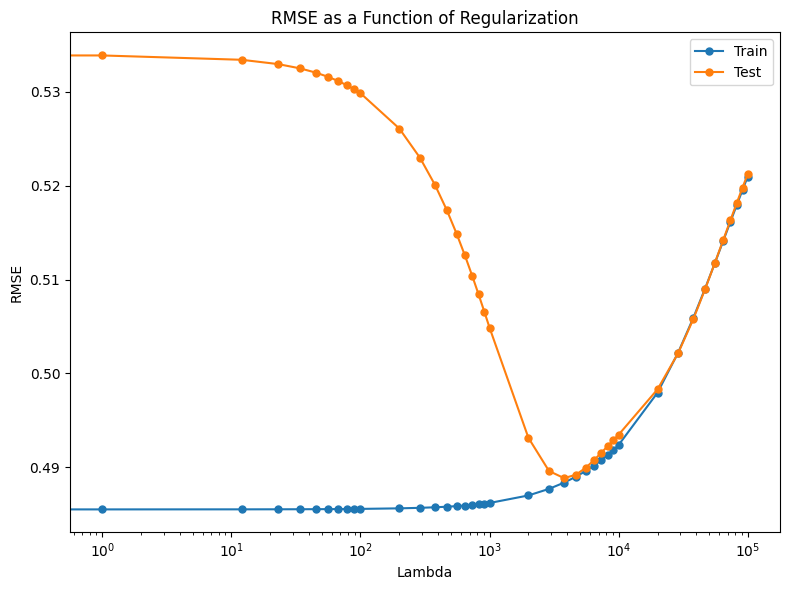

In [18]:
# Turn results into a dataframe
rmse_train_df=pd.DataFrame.from_dict(dict_lbd_rmse_train,orient='index').sort_index().reset_index()
rmse_val_df=pd.DataFrame.from_dict(dict_lbd_rmse_val,orient='index').sort_index().reset_index()
rmse_train_df.columns=['lambda','rmse_train']
rmse_val_df.columns=['lambda','rmse_validation']
merged_rmse=pd.merge(rmse_train_df,rmse_val_df,on='lambda').set_index('lambda')


# Figure
fig, ax = plt.subplots(1, figsize=(8, 6))
merged_rmse['rmse_train'].plot(ax=ax, marker='.', markersize=10, label='Train')
merged_rmse['rmse_validation'].plot(ax=ax, marker='.', markersize=10, label='Test')
ax.set_xscale('log')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_xlabel('Lambda')
ax.set_ylabel('RMSE')
ax.set_title('RMSE as a Function of Regularization')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [19]:
alpha, betas = multivariate_regularized_ols(x_train_norm,y_train,R=0.001, MaxIterations=10**5, lmbda=6500)

y_hat_test = alpha
for i in range(len(features)):
    y_hat_test += betas[i] * x_test_norm.iloc[:,i]
rmse_test = compute_rmse(y_hat_test,y_test)
res_test.append(rmse_test)
print(rmse_test,"\n")

cost < 0.00001 stopped after iteration times: 5414
Time taken: 0.57 seconds
0.4841480950263209 



The polynomial features overfit only on some realizations of the data, as suggested by the performance of the cross-validations splits. This "unlucky" draws are "bad" enough to make the out-of-sample average RMSE of the unregularized models higher than those with stronger regularization by a margin of ~$3k. The optimal cross-validated value for lambda is 6*10**3. The test error is slightly lower than the estimates from 3.2, even though as the previous discussion suggests, we shouldn't be putting too much stock in the minor improvement in the test estimate. Overall, the polynomial features seem to be adding very little to the performance and instead adding risk and complexity. This results highlight the importance of using validation to assess the stability of model performance. 

### 4.5: Compare your results to sklearn ridge [extra-credit]

Repeat your analysis in 4.4, but this time use the sklearn implementation of ridge regression (sklearn.linearmodel.Ridge). Are the results similar? How would you explain the differences, if any?

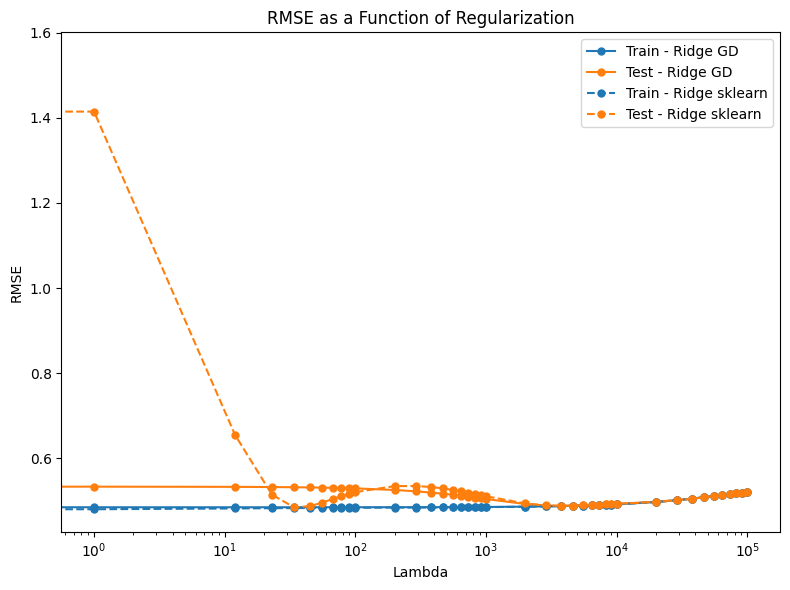

In [20]:
# Your code here

# Turn results into a dataframe
rmse_train_df=pd.DataFrame.from_dict(dict_lbd_rmse_train,orient='index').sort_index().reset_index()
rmse_val_df=pd.DataFrame.from_dict(dict_lbd_rmse_val,orient='index').sort_index().reset_index()
rmse_train_df.columns=['lambda','rmse_train']
rmse_val_df.columns=['lambda','rmse_validation']
merged_rmse=pd.merge(rmse_train_df,rmse_val_df,on='lambda').set_index('lambda')

# Turn results into a dataframe
rmse_train_df_ridge = pd.DataFrame.from_dict(dict_lbd_rmse_train_ridge,orient='index').sort_index().reset_index()
rmse_val_df_ridge = pd.DataFrame.from_dict(dict_lbd_rmse_val_ridge,orient='index').sort_index().reset_index()
rmse_train_df_ridge.columns=['lambda','rmse_train']
rmse_val_df_ridge.columns=['lambda','rmse_validation']
merged_rmse_ridge=pd.merge(rmse_train_df_ridge,rmse_val_df_ridge,on='lambda').set_index('lambda')

# Figure
fig, ax = plt.subplots(1, figsize=(8, 6))
merged_rmse['rmse_train'].plot(ax=ax, marker='.', markersize=10, label='Train - Ridge GD')
merged_rmse['rmse_validation'].plot(ax=ax, marker='.', markersize=10, label='Test - Ridge GD')
merged_rmse_ridge['rmse_train'].plot(ax=ax, marker='.', markersize=10,linestyle='--', label='Train - Ridge sklearn',color='#1f77b4')
merged_rmse_ridge['rmse_validation'].plot(ax=ax, marker='.', markersize=10,linestyle='--',label='Test - Ridge sklearn',color='#ff7f0e')
ax.set_xscale('log')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.set_xlabel('Lambda')
ax.set_ylabel('RMSE')
ax.set_title('RMSE as a Function of Regularization')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

The results are largely aligned, the differences are probaby explained by (i) the fact that sklearn uses different solvers that do not correspond exactly to our GD implementation and (ii) sklearn implementation is in all likelihood more effcient and careful in dealing with numeric issues. 

### 4.6: AdaGrad [extra-credit]

AdaGrad is a method to implement gradient descent with different learning rates for each feature. Adaptive algorithms like this one are being extensively used especially in neural network training. Implement AdaGrad on 2.3 using `MedInc`, `HouseAge` and `AveRooms` as independent variables. Standardize these variables before inputting them to the gradient descent algorithm. Tune the algorithm until you estimate the regression coefficients within a tolerance of 1e-1. Use mini-batch gradient descent in this implementation. In summary for each parameter (in our case one intercept and three slopes) the update step of the gradient (in this example $\beta_j$) at iteration $k$ of the GD algorithm becomes:

$$\beta_j=\beta_j -\frac{R}{\sqrt{G^{(k)}_j}}\frac{\partial J(\alpha,\beta_1,\ldots)}{\partial \beta_j}$$ where
$G^{(k)}_j=\sum_{i=1}^{k} (\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j})^2$ and $R$ is your learning rate. The notation $\frac{\partial J^{(i)}(\alpha,\beta_1,\ldots)}{\partial \beta_j}$ corresponds to the value of the gradient at iteration $(i)$. Essentially we are "storing" information about previous iteration gradients. Doing that we effectively decrease the learning rate slower when a feature $x_i$ is sparse (i.e. has many zero values which would lead to zero gradients). Although this method is not necessary for our regression problem, it is good to be familiar with these methods as they are widely used in neural network training.  

In [ ]:
"""
Function
--------
multivariate_ols
    Gradient Decent to minimize OLS. 
    
Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations
    

Returns
-------
alpha: float
    intercept
    
beta_array: array[float]
    co-efficient
"""

def AdaGrad_ols(xvalue_matrix, yvalues, R=0.00001, MaxIterations=10000):
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)[:, np.newaxis]
    n, variable_n = xvalue_matrix.shape # sample number, varaibels number
    # initialize parameters
    params = np.random.randn(variable_n + 1, 1)
    cost = np.inf
    epsilon = 0.00001
    G = np.zeros((variable_n + 1, variable_n + 1))
    for i in range(MaxIterations):
        g = np.zeros((variable_n + 1, 1))
        cost_old = cost
        part_1 = params[0] + np.dot(xvalue_matrix, params[1:variable_n + 1]) - yvalues
        # populate gradient vector
        g[0] = part_1.sum()
        g[1:variable_n + 1] = np.dot(xvalue_matrix.T, part_1)
        # store outer product of past values of gradients 
        G += np.outer(g, g)
        # update parameters (gd steps)
        for j in range(variable_n + 1):
            params[j] -= R / n * g[j]/np.sqrt(np.diag(G)[j])
        part_2 = params[0] + np.dot(xvalue_matrix, params[1:variable_n + 1]) - yvalues
        #print(params[2])
        cost = 1.0 / (2 * n) * ((part_2 ** 2).sum())
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return params